In [1]:
import numpy as np 
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.integrate import odeint

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
# Paquetes para mutual information
from sklearn import metrics
from sklearn import feature_selection

## Sistema de Rössler

Se utilizará el método de coordenadas de retraso, para la reconstrucción del atractor a partir de la serie de tiempo. 

$$ \frac{dx}{dt} = -y - z$$

$$ \frac{dy}{dy} = x + a y $$

$$ \frac{dz}{dt} = b + z(x - c)$$

In [3]:
#---- Definiendo integrador RK4
def rk4(odes, state, parameters, dt=0.01):
    k1 = dt * odes(state, parameters)
    k2 = dt * odes(state + 0.5 * k1, parameters)
    k3 = dt * odes(state + 0.5 * k2, parameters)
    k4 = dt * odes(state + k3, parameters)
    return state + (k1 + 2 * k2 + 2 * k3 + k4) / 6

#---- Definiendo generador de serie de tiempo 
def generate(data_length, odes, state, parameters):
    data = numpy.zeros([state.shape[0], data_length])

    for i in range(5000): #Descarta todos los estados hasta el transciente
        state = rk4(odes, state, parameters)

    for i in range(data_length): #Solo almacena los estados despues del transciente
        state = rk4(odes, state, parameters)
        data[:, i] = state

    return data

In [4]:
#---- Ecuaciones diferenciales del sistema
def rossler_odes(r, kk):
    x, y, z = r
    a, b, c = kk
    
    dx = -y - z
    dy = x + a * y
    dz = b + z * (x - c)
    
    return numpy.array([dx, dy, dz])

#---- Generador especificamente de Rossler
def rossler_generate(data_length):
    return generate(data_length, rossler_odes, \
        numpy.array([2.0, 1.0, 1.0]), numpy.array([0.4, 2, 4])) 
        # en este array estan las condiciones iniciales y los argumentos

In [5]:
#Generando serie de tiempo de longitud 2e13
data_Rossler = rossler_generate(2**13)

X_ros = data_Rossler[0]; Y_ros = data_Rossler[1]; Z_ros = data_Rossler[2]

Text(0, 0.5, 'z(t)')

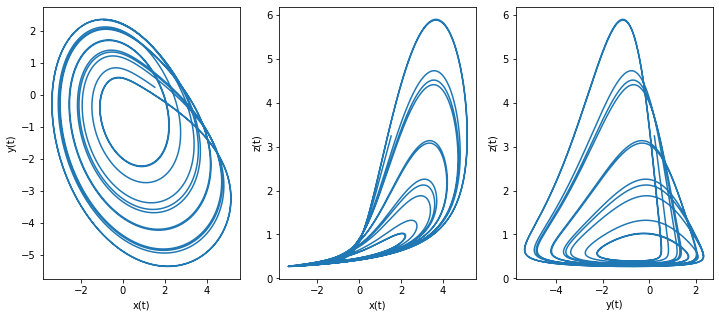

In [6]:
#Graficando proyecciones 

fig = plt.figure(figsize=(12, 5))
ax0 = fig.add_subplot(131); ax1 = fig.add_subplot(132); ax2 = fig.add_subplot(133)

ax0.plot(X_ros, Y_ros)
ax1.plot(X_ros, Z_ros)
ax2.plot(Y_ros, Z_ros)

ax0.set_xlabel("x(t)"); ax0.set_ylabel("y(t)")
ax1.set_xlabel("x(t)"); ax1.set_ylabel("z(t)")
ax2.set_xlabel("y(t)"); ax2.set_ylabel("z(t)")

Text(0.5, 0, 'z(t)')

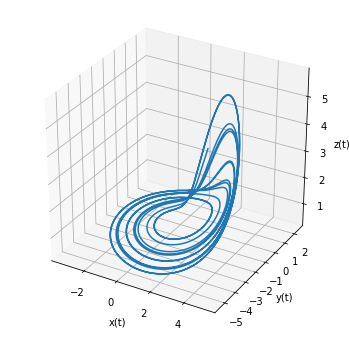

In [7]:
# Graficando espacio de fase 

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection='3d')

ax.plot(X_ros, Y_ros, Z_ros)

ax.set_xlabel("x(t)"); ax.set_ylabel("y(t)"); ax.set_zlabel("z(t)")

## Encontrar $\tau$ 

In [68]:
##--- Hallando tau más optimo con mutual information
tau = np.arange(0, 500)

Xprim = np.asmatrix(X_ros).transpose()

M = []
I = []
m_0 = 10000
for i in tau:
    datX = numpy.roll(X_ros, -i)
    m_i = feature_selection.mutual_info_regression(Xprim, datX)
    #print(i, m_0, m_i)
    M.append(m_i)
    I.append(i)
    
    if m_i > m_0:
        print('first minimun', m_i)
        print('tau =', i)
        break
    else:
        m_0 = m_i  

first minimun [1.49736754]
tau = 137


In [81]:
## Para gráficar toda la función de información mutua
MI = []
for i in tau:
    datX = numpy.roll(X_ros, -i)
    m_i = feature_selection.mutual_info_regression(Xprim, datX)
    MI.append(m_i)

Text(0.5, 1.0, '$X_{ros}$')

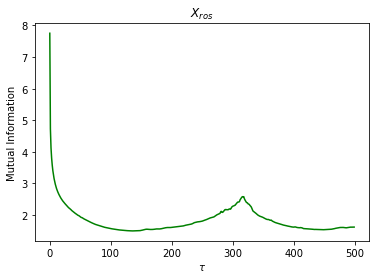

In [89]:
plt.plot(tau, MI, 'g-')
plt.xlabel(r'$\tau$')
plt.ylabel("Mutual Information")
plt.title(r'$X_{ros}$')

In [90]:
##--- Las nuevas coordenadas dadas por el tau encontrado
Tau = 137

X0_prim = X_ros
X1_prim = np.roll(X_ros, -Tau)
X2_prim = np.roll(X_ros, -2*Tau)

Text(0.5, 0, "X2'(t)")

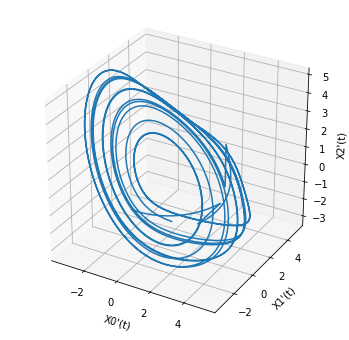

In [91]:
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection='3d')

ax.plot(X0_prim, X1_prim, X2_prim)

ax.set_xlabel("X0'(t)"); ax.set_ylabel("X1'(t)"); ax.set_zlabel("X2'(t)")